# <center> ИССЛЕДОВАНИЕ ДАННЫХ HR-АГЕНТСТВА

## Постановка задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

Исследуйте данные и сделайте выводы по полученным результатам. Подкрепите свои рассуждения и выводы визуализациями и с помощью статистического тестирования проверьте, являются ли выводы статистически значимыми.

В процессе своего анализа вы должны:

1. Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
2. А также ответить на ключевые вопросы HR-агентства:
    * Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
    * Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
    * Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
    * Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

Если вы найдёте в данных интересные закономерности, также отметьте их в своём анализе.

Продемонстрируйте использование разных тестов для проверки статистической значимости сделанных выводов:

* тесты для количественного признака:
    * для одной выборки;
    * для двух выборок;
    * для нескольких выборок;
* тест для категориальных признаков.


Данные содержат следующие столбцы:
|НАИМЕНОВАНИЕ СТОЛБЦА  | ОПИСАНИЕ                                |
|:-------------------- |:---------------------------------------|
|work_year	           |Год, в котором была выплачена зарплата.  |
|experience_level      |Опыт работы на этой должности в течение года  со следующими возможными значениями: <br/> - EN — Entry-level/Junior;<br/> - MI — Mid-level/Intermediate;<br/> - SE — Senior-level/Expert;<br/> - EX — Executive-level/Director.|
|employment_type	   |Тип трудоустройства для этой роли:<br/>- PT — неполный рабочий день;<br/> - FT — полный рабочий день;<br/> - CT — контракт;<br/> - FL — фриланс.|
|job_title	|Роль, в которой соискатель работал в течение года.|
|salary	|Общая выплаченная валовая сумма заработной платы.|
|salary_currency	|Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.|
|salary_in_usd	|Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).|
|employee_residence	|Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.|
|remote_ratio	|Общий объём работы, выполняемой удалённо: <br/> 0 — удалённой работы нет (менее 20 %); <br/> 50 — частично удалённая работа;<br/> 100 — полностью удалённая работа (более 80 %).|
|company_location	|Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.|
|company_size	|Среднее количество людей, работавших в компании в течение года:<br/>S — менее 50 сотрудников (небольшая компания);<br/>M — от 50 до 250 сотрудников (средняя компания);<br/> L — более 250 сотрудников (крупная компания).|

Источник датасета: [“Data Science Job Salaries” (kaggle.com)](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries)

In [31]:
import warnings 
warnings.filterwarnings('ignore')

## <center> Загрузка и обработка данных

In [1]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

In [2]:
# загружаем датасет
data = pd.read_csv('data/ds_salaries.csv')
data.drop('Unnamed: 0',axis=1,inplace=True)
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [3]:
#признак зарплаты будем использовать salary_in_usd, тк он является целым числом(int64) и един для всех
#удаляем неинформативные признаки
data.drop(['salary','salary_currency'],axis=1,inplace=True)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary_in_usd       607 non-null    int64 
 5   employee_residence  607 non-null    object
 6   remote_ratio        607 non-null    int64 
 7   company_location    607 non-null    object
 8   company_size        607 non-null    object
dtypes: int64(3), object(6)
memory usage: 42.8+ KB


В датасете 607 записей (без пропущенных значений).

1. Проверим датасет на наличие пропусков и дубликатов.

In [5]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

# Удаляем дубликаты:
data = data.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(data.shape))

Количество дубликатов: 42
Размер таблицы после удаления дубликатов: (565, 9)


In [7]:
data1 = data.copy()
def nan_function(x):
    return np.nan if x == 0 else x
data1['company_location'] = data1['company_location'].apply(nan_function)
data1['company_size'] = data1['company_size'].apply(nan_function)
data1['employee_residence'] = data1['employee_residence'].apply(nan_function)
data1['experience_level'] = data1['experience_level'].apply(nan_function)
data1['job_title'] = data1['job_title'].apply(nan_function)
data1['remote_ratio'] = data1['remote_ratio'].apply(nan_function)
data1['salary_in_usd'] = data1['salary_in_usd'].apply(nan_function)
data1['work_year'] = data1['work_year'].apply(nan_function)
data1.isnull().mean().round(2).sort_values(ascending=False)

remote_ratio          0.21
work_year             0.00
experience_level      0.00
employment_type       0.00
job_title             0.00
salary_in_usd         0.00
employee_residence    0.00
company_location      0.00
company_size          0.00
dtype: float64

Удалим количество полученных дубликатов. Размер таблицы после удаления дубликатов: (565, 9). При проверке пропущенных данных большого числа пропусков не выявлено, оставляем как есть.

2. Определеляем в данных неинформативные признаки, которые не будут участвовать в исследовании.

In [8]:
#список неинформативных признаков
low_information_cols = [] 

#цикл по всем столбцам
for col in data.columns:
    #наибольшая относительная частота в признаке
    top_freq = data[col].value_counts(normalize=True).max()
    #доля уникальных значений от размера признака
    nunique_ratio = data[col].nunique() / data[col].count()
    # сравниваем наибольшую частоту с порогом
    if top_freq > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')
    # сравниваем долю уникальных значений с порогом
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')

employment_type: 96.64% одинаковых значений


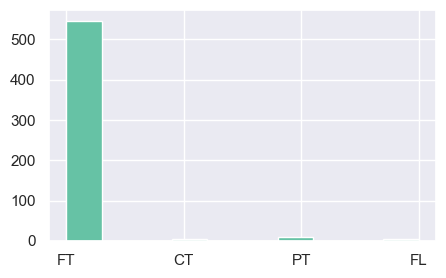

In [9]:
data['employment_type'].hist(figsize=(5,3));

Признак employment_type содержит в себе 96.64% одинаковых значений, как видно из диаграммы почти все значения это  FT — полный рабочий день. Признак является неинформативным, избавляемся от него.

In [10]:
#удаляем неинформативные признаки
data.drop(low_information_cols ,axis=1,inplace=True)

3. Классифицируем все признаки на числовые и категориальные

In [25]:
#Сделаем преобразование столбцов к типу данных category:

cols_to_exclude = ['work_year', 'salary_in_usd'] # список столбцов, которые мы не берём во внимание
max_unique_count = 60 # задаём максимальное число уникальных категорий
for col in data.columns: # цикл по именам столбцов
    if data[col].nunique() < max_unique_count and col not in cols_to_exclude: # проверяем условие
        data[col] = data[col].astype('category') # преобразуем тип столбца
display(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 565 entries, 0 to 606
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   work_year           565 non-null    int64   
 1   experience_level    565 non-null    category
 2   job_title           565 non-null    category
 3   salary_in_usd       565 non-null    int64   
 4   employee_residence  565 non-null    category
 5   remote_ratio        565 non-null    category
 6   company_location    565 non-null    category
 7   company_size        565 non-null    category
dtypes: category(6), int64(2)
memory usage: 24.4 KB


None

Наш датасет имеет большое количество признаков типа "object", их можно перевести в формат категории и сохранить место в памяти компьютера, а также ускорить процесс работы.

4. Находим основные статистические характеристики для каждого из признаков.

In [13]:
round(data.describe())

,work_year,salary_in_usd
count,565.0,565.0
mean,2021.0,110610.0
std,1.0,72281.0
min,2020.0,2859.0
25%,2021.0,60757.0
50%,2021.0,100000.0
75%,2022.0,150000.0
max,2022.0,600000.0


In [26]:
data.describe(include='category')

,experience_level,job_title,employee_residence,remote_ratio,company_location,company_size
count,565,565,565,565,565,565
unique,4,50,57,3,50,3
top,SE,Data Scientist,US,100,US,M
freq,243,130,295,346,318,290


Мы прочитали датасет, избавились от дубликатов и неинформативных признаков. Классифицировали все признаки на числовые и категориальные. Нашли основные статистики признаков.

## <center> Разведывательный анализ данных

### <center>  Визуальный анализ данных

Построим распеределение всех возможных признаков быстро простой визуализацией

Для чиловых:

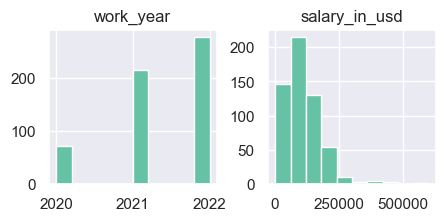

In [103]:
data.hist(figsize=(5,2));

Для категориальных:

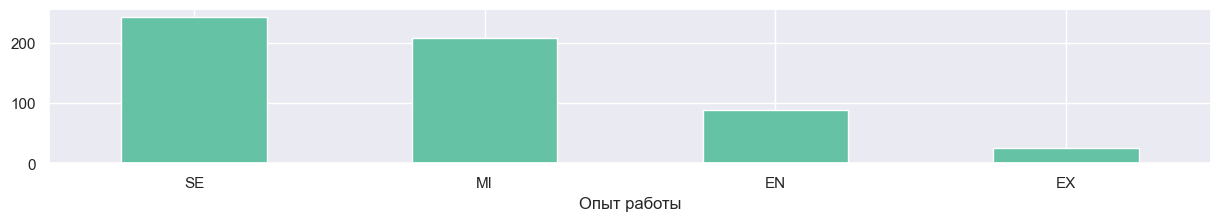

In [18]:
data['experience_level'].value_counts().plot(kind='bar', xlabel='Опыт работы', rot=0,figsize=(15,2));

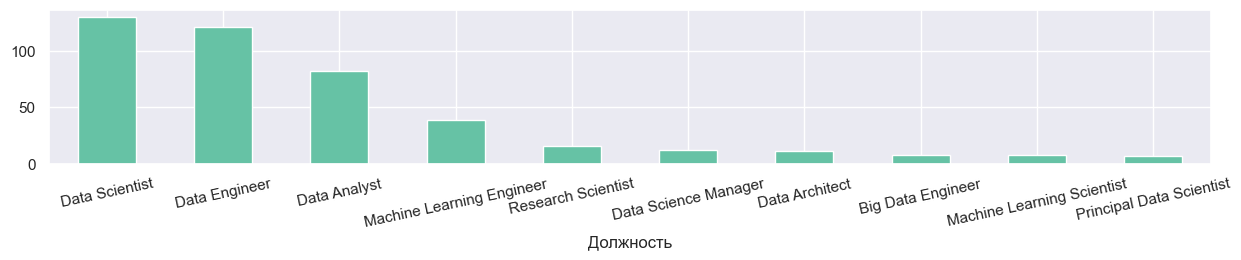

In [22]:
data['job_title'].value_counts().nlargest(10).plot(kind='bar', xlabel='Должность', rot=12,figsize=(15,2));

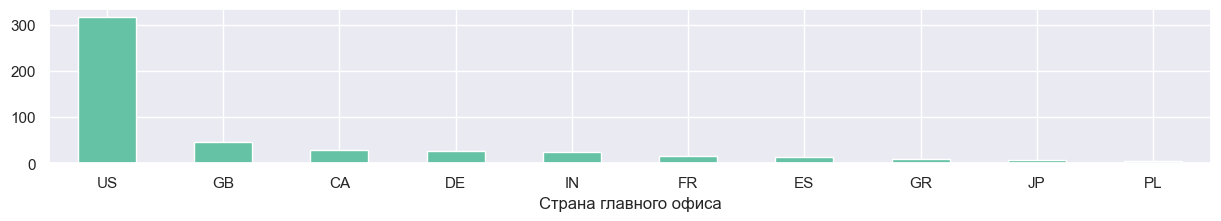

In [19]:
data['company_location'].value_counts().nlargest(10).plot(kind='bar', xlabel='Страна главного офиса', rot=0,figsize=(15,2));

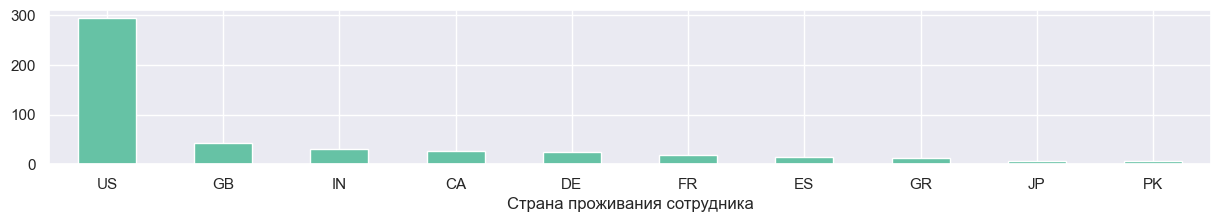

In [21]:
data['employee_residence'].value_counts().nlargest(10).plot(kind='bar', xlabel='Страна проживания сотрудника', rot=0,figsize=(15,2));

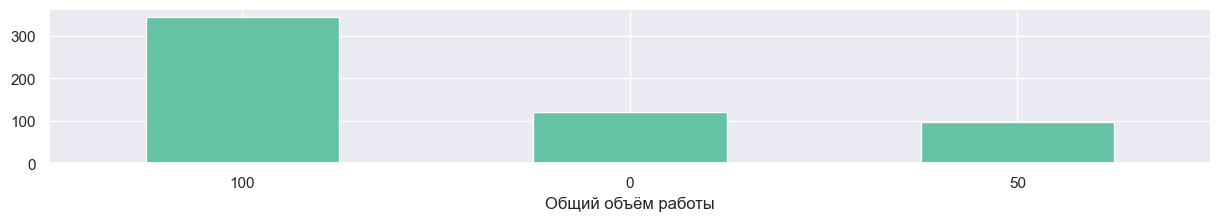

In [23]:
data['remote_ratio'].value_counts().nlargest(10).plot(kind='bar', xlabel='Общий объём работы', rot=0,figsize=(15,2));

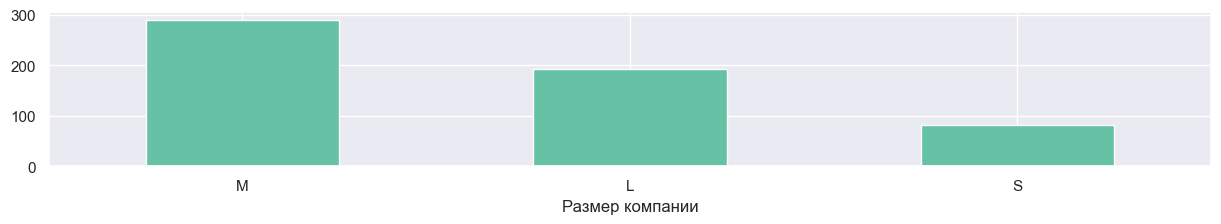

In [24]:
data['company_size'].value_counts().nlargest(10).plot(kind='bar', xlabel='Размер компании', rot=0,figsize=(15,2));

Сделан базовый анализ для каждого признака, участвующего в исследовании:
* для числовых признаков построены гистограммы, иллюстрирующие распределения;
* для категориальных признаков определено количество записей для каждой категории и построены соответствующие визуализации.

## <center> Влияние каждого из признаков, участвующих в исследовании, на зарплату по всем наименованиям Data Scientist или на зарплату по всем должностям.

In [27]:
#создаем датафрейм 
df_ds=data[data['job_title']=='Data Scientist']

### Распределение зарплат у Data Scientist

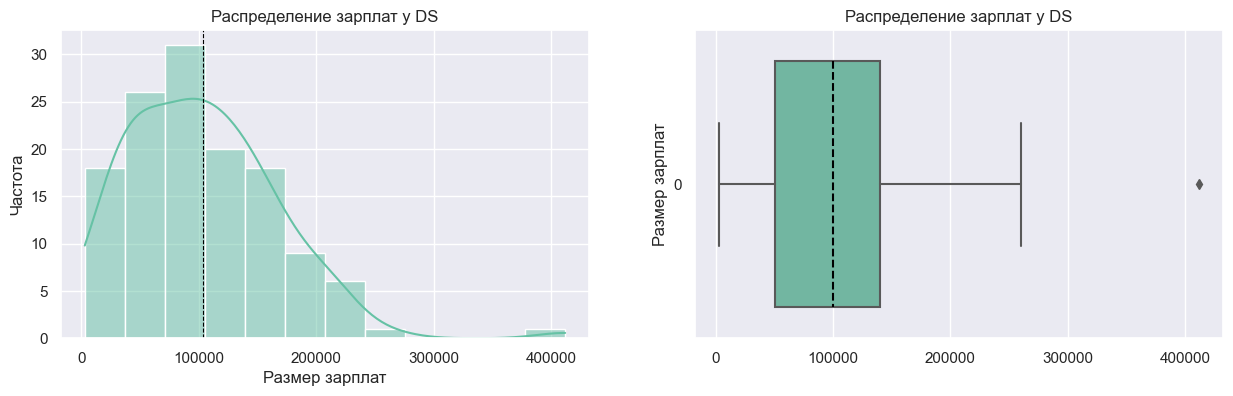

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

sns.histplot(df_ds['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Размер зарплат', ylabel='Частота')
axes[0].set_title('Распределение зарплат у DS')
axes[0].axvline(df_ds['salary_in_usd'].mean(), color='black', linestyle='--', linewidth=0.8)

sns.boxplot(df_ds['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "black", "linestyle": '--'})
axes[1].set(ylabel='Размер зарплат')
axes[1].set_title('Распределение зарплат у DS')

plt.show()

In [9]:
data_agg = df_ds['salary_in_usd'].describe().round(2).to_frame()
data_agg.columns = ['Размер зарплат у DS']
data_agg

,Размер зарплат
count,130.00
mean,103336.35
std,63967.56
min,2859.00
25%,50330.25
50%,100000.00
75%,140400.00
max,412000.00


Распределение правосторонее. Распределение зарплат у Data Scientist смещено вправо: большинство сотрудников зарабатывают от 50 до 100 тысяч долларов, но есть и такие сотрудники, которые зарабатывают гораздо больше.

### Распределение зарплат у DS по странe проживания сотрудника

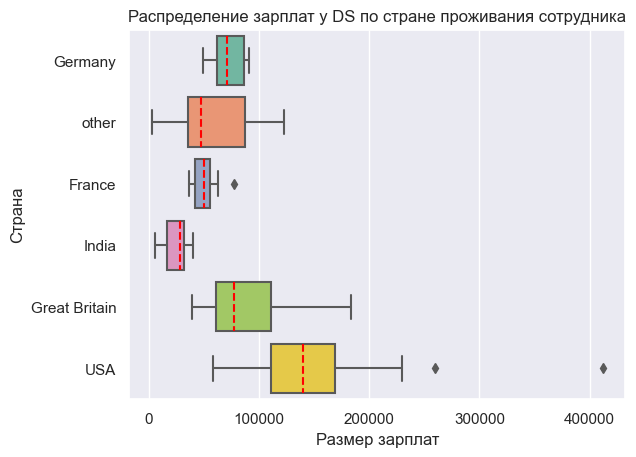

In [33]:
pop_residence = df_ds['employee_residence'].value_counts().nlargest(6).index
df_ds['employee_residence'] = df_ds['employee_residence'].apply(lambda x: x if x in pop_residence else 'other')
df_ds['employee_residence'] = df_ds['employee_residence'].replace(
    ['US','GB','IN','CA','DE','FR'],['USA','Great Britain','India','Canada','Germany','France'])

ax = sns.boxplot(df_ds, x='salary_in_usd', y='employee_residence', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='Страна')
plt.title('Распределение зарплат у DS по странe проживания сотрудника')
plt.show()

In [34]:
data_agg = df_ds.groupby('employee_residence')['salary_in_usd'].describe().round(2).sort_values(by='mean',ascending=False)
print('Распределение зарплат у DS по странe проживания сотрудника')
data_agg

Распределение зарплат у DS по странe проживания сотрудника


,count,mean,std,min,25%,50%,75%,max
employee_residence,,,,,,,,
USA,66.0,147082.58,54499.36,58000.0,110500.00,140200.0,169250.00,412000.0
Great Britain,11.0,88177.36,41393.50,39263.0,60847.00,76958.0,110808.00,183228.0
Germany,6.0,72113.67,16752.86,49268.0,61781.75,71279.5,86448.75,90734.0
other,30.0,56525.77,34852.17,2859.0,35626.25,47404.5,87479.25,122346.0
France,8.0,51665.62,13412.16,36643.0,41626.75,50483.5,55575.50,77684.0
India,9.0,23838.33,11758.72,5679.0,16904.00,28399.0,31615.00,40481.0


Распределения зп различны в зависимости от того, в какой стране проживает сотрудник. Самая высокооплачиваемая страна это США.Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

### Распределение зарплат у DS по году

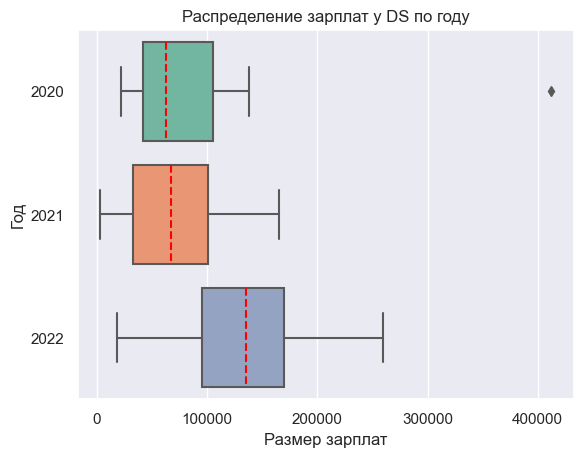

In [35]:
ax = sns.boxplot(df_ds, x='salary_in_usd', y='work_year', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='Год')
plt.title('Распределение зарплат у DS по году')
plt.show()

In [19]:
data_agg = df_ds.groupby('work_year')['salary_in_usd'].describe().round(2)
print('Распределение зарплат у DS по году')
data_agg

Распределение зарплат по году


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,21.0,85970.52,81436.65,21669.0,42197.00,62726.0,105000.00,412000.0
2021,44.0,70215.77,45843.82,2859.0,32793.75,67233.5,100922.75,165000.0
2022,65.0,131366.94,55785.24,18442.0,95550.00,135000.0,170000.00,260000.0


Наблюдается ежегодный рост зарплат у специалистов Data Scientis. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

### Распределение зарплат по должности

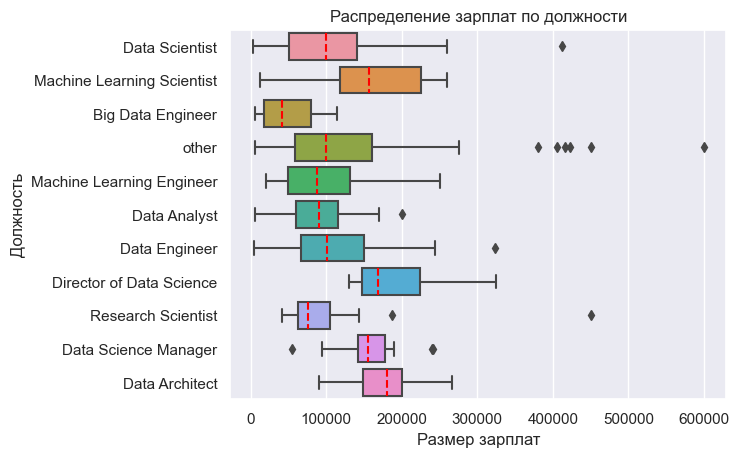

In [36]:
pop_job = data['job_title'].value_counts().nlargest(10).index
data['job_title'] = data['job_title'].apply(lambda x: x if x in pop_job else 'other')

ax = sns.boxplot(data, x='salary_in_usd', y='job_title', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='Должность')
plt.title('Распределение зарплат по должности')
plt.show()

In [31]:
data_agg = data.groupby('job_title')['salary_in_usd'].describe().round(2).sort_values(by='mean',ascending=False)
print('Распределение зарплат по должности')
data_agg

Распределение зарплат по должности


,count,mean,std,min,25%,50%,75%,max
job_title,,,,,,,,
Principal Data Scientist,7.0,215242.43,94705.04,148261.0,156837.00,173762.0,227500.0,416000.0
Data Architect,11.0,177873.91,45714.72,90700.0,148900.00,180000.0,200669.5,266400.0
Machine Learning Scientist,8.0,158412.50,79514.71,12000.0,118075.00,156500.0,225000.0,260000.0
Data Science Manager,12.0,158328.50,52589.18,54094.0,142285.25,155750.0,178050.0,241000.0
other,131.0,119526.11,94735.45,5409.0,58678.50,100000.0,158500.0,600000.0
Data Engineer,121.0,109750.03,58203.68,4000.0,66022.00,100800.0,150000.0,324000.0
Research Scientist,16.0,109019.50,98542.76,42000.0,62176.00,76263.5,105000.0,450000.0
Data Scientist,130.0,103336.35,63967.56,2859.0,50330.25,100000.0,140400.0,412000.0
Machine Learning Engineer,39.0,101165.13,62518.56,20000.0,49173.00,87425.0,131500.0,250000.0


Распределения зп различны для разных должностей. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

### Распределение зарплат у DS по размеру компании

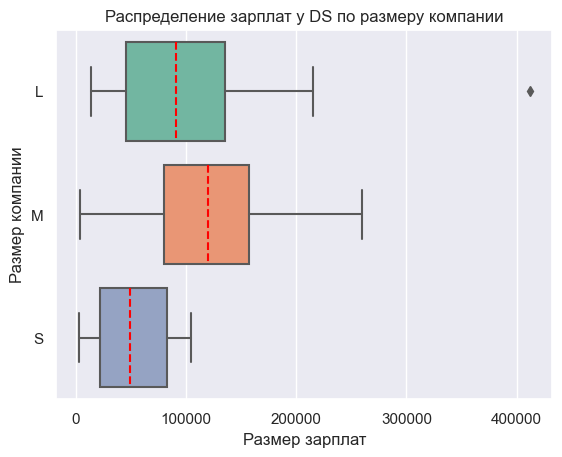

In [37]:
ax = sns.boxplot(df_ds, x='salary_in_usd', y='company_size', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='Размер компании')
plt.title('Распределение зарплат у DS по размеру компании')
plt.show()

In [23]:
data_agg = df_ds.groupby('company_size')['salary_in_usd'].describe().round(2)
print('Распределение зарплат у DS по размеру компании')
data_agg

Распределение зарплат у DS по размеру компании


,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
L,43.0,102743.42,73254.10,13400.0,45240.5,90734.0,135000.0,412000.0
M,66.0,120080.58,56347.79,4000.0,80000.0,119529.5,157500.0,260000.0
S,21.0,51925.76,33216.29,2859.0,21669.0,49268.0,82500.0,105000.0


Распределения зп различны для разных размеров компаний. Сотрудники средних компаний получают больше, чем в маленьких и больших компаниях. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

### Распределение зарплат у DS по опыту работы

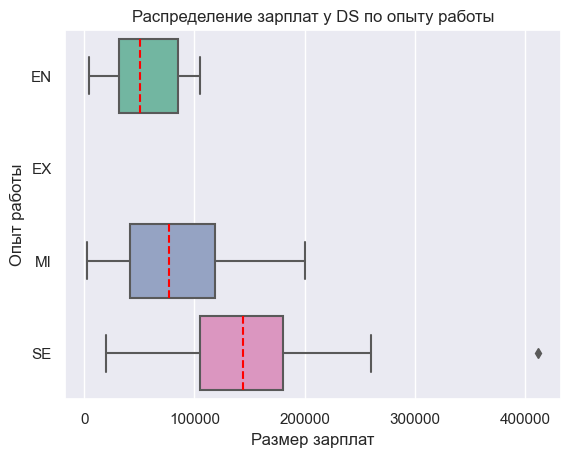

In [38]:
ax = sns.boxplot(df_ds, x='salary_in_usd', y='experience_level', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='Опыт работы')
plt.title('Распределение зарплат у DS по опыту работы')
plt.show()

In [24]:
data_agg = df_ds.groupby('experience_level')['salary_in_usd'].describe().round(2)
print('Распределение зарплат у DS по опыту работы')
data_agg

Распределение зарплат у DS по опыту работы


,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
EN,22.0,55330.91,31237.82,4000.0,31474.0,50483.5,85027.25,105000.0
EX,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MI,59.0,81891.76,47257.88,2859.0,41339.0,76958.0,118529.50,200000.0
SE,49.0,150710.86,62918.63,20171.0,104890.0,144000.0,180000.00,412000.0


Распределения зп различны для разных уровней опыта. Чем выше опыт, тем выше зарплата. Также можно сказать, что у DS отсутсвуют сотрудники уровня EX — Executive-level. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

### Распределение зарплат у DS по общему объёму работы

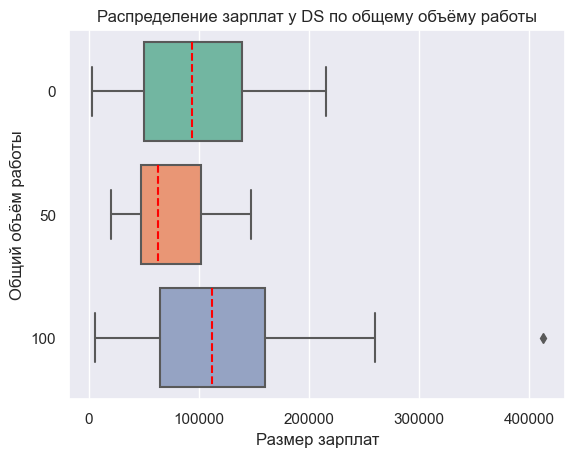

In [39]:
ax = sns.boxplot(df_ds, x='salary_in_usd', y='remote_ratio', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='Общий объём работы')
plt.title('Распределение зарплат у DS по общему объёму работы')
plt.show()

In [26]:
data_agg = df_ds.groupby('remote_ratio')['salary_in_usd'].describe().round(2)
print('Распределение зарплат у DS по общему объёму работы')
data_agg

Распределение зарплат у DS по общему объёму работы


,count,mean,std,min,25%,50%,75%,max
remote_ratio,,,,,,,,
0,38.0,98444.97,58647.60,2859.0,49781.25,93582.0,139050.0,215300.0
50,24.0,73827.83,36204.18,20171.0,47783.75,62726.0,102250.0,147000.0
100,68.0,116484.54,70908.36,5679.0,64420.00,111500.0,160000.0,412000.0


Распределения зп различны для общего объёма работы. Уровень зарплаты повышается в 2-х случаях, если сотрудник не занимается удаленной работой(или ее менее 20%) или же наоборот имеет полностью удалённую работу (более 80 %). Сотрудники с частично удалённой работой удаленной работой получают в среднем на 30% меньше . Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

### Распределение Data Scientist и Data Engineer в разных компаниях

In [40]:
d =data[data['job_title'].isin(['Data Scientist','Data Engineer'])]

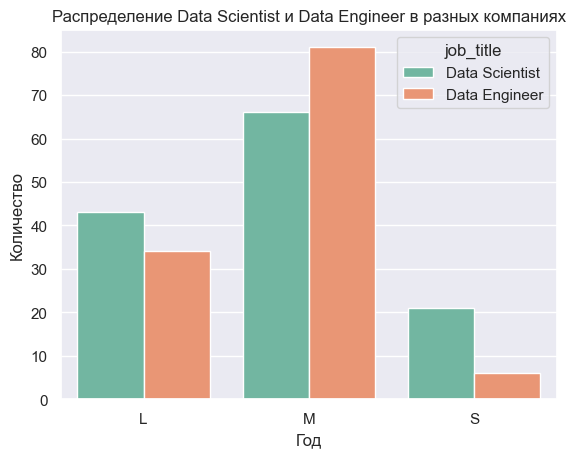

In [41]:
ax = sns.countplot(data=d, x=d['company_size'],hue='job_title')
ax.set(xlabel='Год', ylabel='Количество')
plt.title('Распределение Data Scientist и Data Engineer в разных компаниях')
plt.show()

Распределения специалистов Data Scientist и Data Engineer в разных компаниях показывает нам зависимоть количество сотрудников указанных специальностей от размера компании. Как видно из диаграммы, наибольшее количество сотрудников обеих специальностей сосредаточенов компаниях средних размеров. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

### Cоотношение зарплаты Data Scientist и Data Engineer

In [42]:
#строим сводную таблицу
pivot_2 = d.pivot_table(
    values = 'salary_in_usd',
    columns = 'work_year',
    index = 'job_title',
)
pivot_2.round(2)

work_year,2020,2021,2022
job_title,,,
Data Engineer,88162.00,79434.87,124651.78
Data Scientist,85970.52,70215.77,131366.94


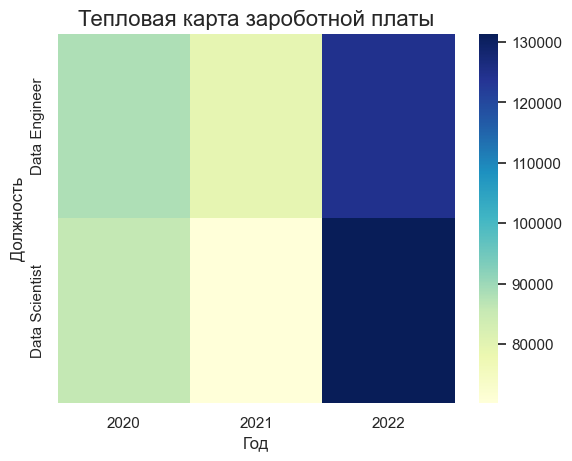

In [43]:
#строим тепловую карту
heatmap = sns.heatmap(data=pivot_2, cmap='YlGnBu')
heatmap.set_title('Тепловая карта зароботной платы', fontsize=16);
heatmap.set_xlabel('Год');
heatmap.set_ylabel('Должность');

Cоотношение зарплаты Data Scientist и Data Engineer как мы видим на диграмме указывают на повышение зарплат у обеих специальностей в 2022 году. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

**«Какие факторы влияют на заработную плату?»**

С помощью визуализаций мы увидели,что все признаки так или иначе влияют на заработную плату должности Data Scientist. Далее в проекте мы проверим насколько визулизации точно отображают суть дел, являются ли они статистически значимыми.

## <center> Статистический анализ данных

In [49]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


In [50]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

### <center>**1. Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?**

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [67]:
# загружаем данные
age2020 = df_ds.loc[df_ds['work_year']==2020, 'salary_in_usd']
age2021 = df_ds.loc[df_ds['work_year']==2021, 'salary_in_usd']
age2022 = df_ds.loc[df_ds['work_year']==2022, 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для 2020:')
result = stats.shapiro(age2020)
decision_normality(result[1])

print('Для 2021:')
result = stats.shapiro(age2021)
decision_normality(result[1])

print('Для 2022:')
result = stats.shapiro(age2022)
decision_normality(result[1])

Для 2020:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для 2021:
p-value = 0.107
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для 2022:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


Чтобы проверить нашу гипотезу, можно использовать критерий Краскела — Уоллиса (однофакторный дисперсионный анализ на рангах)

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): распределение зарплат у DS  по 2020г, 2021г и 2022г одинаковы.

*Альтернативная гипотеза* ($H_1$): распределение зарплат у DS  по 2020г, 2021г и 2022г неодинаковы.

In [58]:
# проводим тест
_, p = stats.kruskal(age2020, age2021, age2022)

decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна — Уитни для сравнения распределений на основе рангов.

Сформулируем гипотезы:

* Нулевая гипотеза: Ежегодно зарплата у специалистов Data Scientist одинаковая.
* Альтернативная гипотеза: Ежегодно зарплата у специалистов Data Scientist растет.

In [68]:
_, p = stats.mannwhitneyu(age2020, age2021)
decision_hypothesis(p)

p-value = 0.599
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


In [69]:
_, p = stats.mannwhitneyu(age2021, age2022)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод:**

 Мы можем предположить, что размер зарплат от года к году изменяется. Статистическим методом мы проверили отдельно каждый год. Из этого можно сделать вывод, что между 2020 годом и 2021 зарплата не изменилась. А между 2021 годом 2022 наблюдается тенденция к росту.

### <center>**2. Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?**

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [66]:
# загружаем данные
ds = data.loc[data['work_year']==2022, 'salary_in_usd']
de = data.loc[data['work_year']==2022, 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для DS:')
result = stats.shapiro(ds)
decision_normality(result[1])

print('Для DE:')
result = stats.shapiro(de)
decision_normality(result[1])

Для DS:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для DE:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна — Уитни, чтобы оценить различия распределений признака в двух независимых группах.

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): распределение зарплат у DS и DE в 2022 году одинаковы.

*Альтернативная гипотеза* ($H_1$): распределение зарплат у DS и DE в 2022 году неодинаковы.

In [56]:
# проводим тест
_, p = stats.mannwhitneyu(ds,de)

decision_hypothesis(p)

p-value = 1.000
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Ввод:** 

Распределение зарплат у Data Scientist и Data Engineer в 2022 году одинаковое.

### <center>**3. Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?**

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [65]:
# загружаем данные
s = df_ds.loc[df_ds['company_size']=="S", 'salary_in_usd']
m = df_ds.loc[df_ds['company_size']=="M", 'salary_in_usd']
l = df_ds.loc[df_ds['company_size']=="L", 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для "S":')
result = stats.shapiro(s)
decision_normality(result[1])

print('Для "M":')
result = stats.shapiro(m)
decision_normality(result[1])

print('Для "L":')
result = stats.shapiro(l)
decision_normality(result[1])

Для "S":
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для "M":
p-value = 0.897
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для "L":
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


Чтобы проверить нашу гипотезу, можно использовать критерий Краскела — Уоллиса (однофакторный дисперсионный анализ на рангах)

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): распределение зарплат у всех компаний равны:
$$H_0: s = m = l$$

*Альтернативная гипотеза* ($H_1$): распределение зарплат у всех компаний  не равны:
$$H_1 s \neq m \neq l$$

In [60]:
# проводим тест
_, p = stats.kruskal(s,m,l)

decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Чтобы проверить нашу гипотезу, можно использовать двухвыборочный t-критерий, для сравнения средних значений в двух независимых группах.

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): Зарплаты специалистов Data Scientist в компаниях размера "M"($\mu_1$)меньше или равны зарплатам  в компаниях размера "S"($\mu_2$).
$$H_0 : \mu_1 \leq \mu_2$$

*Альтернативная гипотеза* ($H_1$): Зарплаты специалистов Data Scientist в компаниях размера "M"($\mu_1$)больше зарплат в компаниях размера "S"($\mu_2$).
$$H_1 : \mu_1 > \mu_2$$

In [74]:
# проводим тест Левена на равенство дисперсий
print('Тест на равенство дисперсий')
result = stats.levene(s,m)
p = result[1]
print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')

Тест на равенство дисперсий
p-value = 0.018
Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.


In [75]:
# проводим тест на сравнение средних в группах
print('\nТест на равенство средних')
_, p = stats.ttest_ind(s,m, alternative='less', equal_var=False)
decision_hypothesis(p)


Тест на равенство средних
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


В компаниях  средних размеров заплата больше, чем в маленьких.

Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна — Уитни для сравнения распределений на основе рангов.

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): Зарплаты специалистов Data Scientist в компаниях различных размеров одинаковые.

*Альтернативная гипотеза* ($H_1$): Зарплаты специалистов Data Scientist в компаниях различных размеров разные.

In [76]:
_, p = stats.mannwhitneyu(m,l)
decision_hypothesis(p)

p-value = 0.048
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Ввод:** 

Компании различных размеров имеют разные уровни зарплаты для специалистов Data Scientist.

### <center>**4. Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?**

Чтобы проверить нашу гипотезу, можно использовать критерий хи-квадрат, который позволяет оценить, связаны ли между собой два категориальных признака.

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: Наличие связи между должностями Data Scientist и Data Engineer и размером компании отсутствует

*Альтернативная гипотеза*: Наличие связи между должностями Data Scientist и Data Engineer и размером компании отображено

In [64]:
# вычисляем таблицу сопряжённости
cross_table = pd.crosstab(d['job_title'],d['company_size'])
cross_table

company_size,L,M,S
job_title,,,
Data Engineer,34,81,6
Data Scientist,43,66,21


In [65]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_table)

decision_hypothesis(p)

p-value = 0.005
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод:** 

У нас нет оснований утверждать о взаимосвязи между наличием должностей Data Scientist и Data Engineer и размером компании

## <center> Дополнительное исследование

* Размер заработной платы в зависимости от опытa работы и размерa компании

In [111]:
#посмотрим на распределение з/п в зависимости от признаков опыт работы и размер компании
df_ds.groupby(['experience_level','company_size'])['salary_in_usd'].describe().round(2)

count       mean       std      min        25%  \
experience_level company_size                                                   
EN               L               6.0   38365.00  16034.29  13400.0   31474.00   
                 M               9.0   56345.11  36340.56   4000.0   28399.00   
                 S               7.0   68569.14  30763.04  21669.0   50294.50   
MI               L              22.0   85263.41  40580.50  31615.0   42860.75   
                 M              25.0  100973.48  46419.79  33808.0   65438.00   
                 S              12.0   35956.83  27897.97   2859.0   12042.25   
SE               L              15.0  154132.13  91927.54  20171.0  111845.50   
                 M              32.0  152933.59  45392.33  77684.0  119567.25   
                 S               2.0   89487.50   2474.17  87738.0   88612.75   

                                    50%        75%       max  
experience_level company_size                                 
EN               L              38321.5   49297.00   58000.0  
                 M              49646.0   86703.00  100000.0  
                 S              62726.0   95000.00  105000.0  
MI               L              84243.5  116435.50  160000.0  
                 M             100000.0  130000.00  200000.0  
                 S              33864.5   51681.50   82500.0  
SE               L             140400.0  192650.00  412000.0  
                 M             148000.0  180000.00  260000.0  
                 S              89487.5   90362.25   91237.0

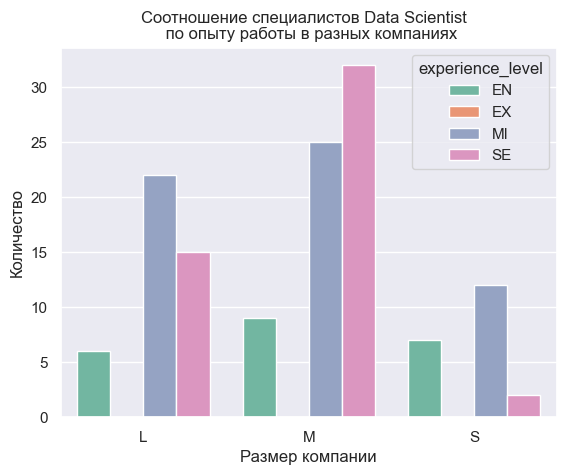

In [121]:
#строим график
ax = sns.countplot(data=df_ds, x='company_size', hue='experience_level')
ax.set(xlabel='Размер компании', ylabel='Количество')
plt.title('Соотношение специалистов Data Scientist  \n по опыту работы в разных компаниях')
plt.show()

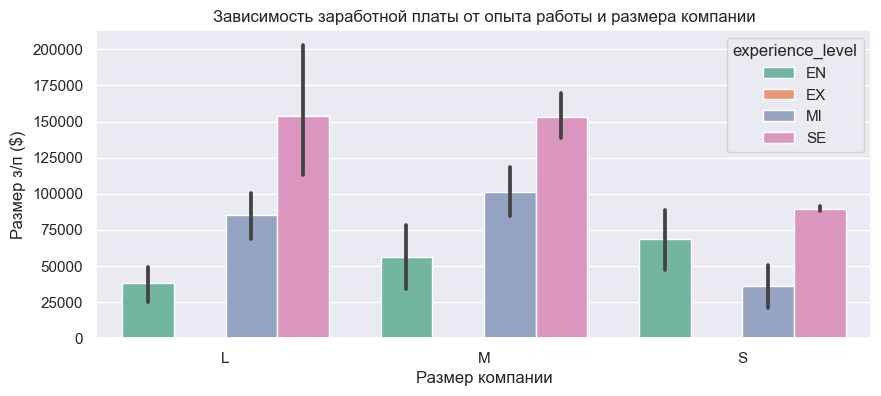

In [88]:
#строим график 
fig = plt.figure(figsize=(10, 4))

barplot = sns.barplot(
    data=df_ds,
    x='company_size',
    y='salary_in_usd',
    hue='experience_level'
)
barplot.set(xlabel='Размер компании', ylabel='Размер з/п ($)')
barplot.set_title('Зависимость заработной платы от опыта работы и размера компании');

### <center> **Влияет ли опыт работы и размер компании на зарплату? (рассматриваем все компании только с уровнем "EN")**

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

In [122]:
# загружаем данные
s = df_ds.loc[(df_ds['company_size']=='S') & (data['experience_level']=='EN'), 'salary_in_usd']
m = df_ds.loc[(df_ds['company_size']=='M') & (data['experience_level']=='EN'), 'salary_in_usd']
l = df_ds.loc[(df_ds['company_size']=='L') & (data['experience_level']=='EN'), 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для S:')
result = stats.shapiro(s)
decision_normality(result[1])

print('Для M:')
result = stats.shapiro(m)
decision_normality(result[1])

print('Для L:')
result = stats.shapiro(l)
decision_normality(result[1])

Для S:
p-value = 0.570
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для M:
p-value = 0.353
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для L:
p-value = 0.899
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


Чтобы проверить нашу гипотезу, можно использовать oднофакторный дисперсионный анализ (ANOVA)** используют, чтобы сравнить средние значения в более чем двух независимых группах

Сформулируем гипотезы в математическом виде:

* Нулевая гипотеза: Зарплаты специалистов Data Scientist в компаниях различных размеров(S($m_1$),  M($m_2$) , L($m_3$)) и опытом работы "EN"  одинаковое.
$$H_0: m_1 =m_2 =m_3$$

* Альтернативная гипотеза: Зарплаты специалистов Data Scientist в компаниях различных размеров(S($m_1$),  M($m_2$) , L($m_3$)) и опытом работы "EN"  не одинаковое.
$$H_1: m_1 \neq m_2 \neq m_3$$

In [123]:
# проводим тест Левена на равенство дисперсий
print('Тест на равенство дисперсий')
result = stats.levene(s,m,l)
p = result[1]
print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, нужно использовать непараметрический тест')
else:
    print('Дисперсии одинаковы, мы можем использовать тест ANOVA')

# проводим тест на сравнение средних в группах
print('\nТест на равенство средних')
_, p = stats.f_oneway(s,m,l)

decision_hypothesis(p)

Тест на равенство дисперсий
p-value = 0.095
Дисперсии одинаковы, мы можем использовать тест ANOVA

Тест на равенство средних
p-value = 0.227
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод:**

 Нет оснований утверждать, что в разных компаниях специалисты с уровнем 'EN' получают разные выплаты .

### <center>**Чем выше уровень классификации, тем выше уровень зарплаты у специалиста Data Scientist?**

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [64]:
# загружаем данные
en = df_ds.loc[df_ds['experience_level']=="EN", 'salary_in_usd']
mi = df_ds.loc[df_ds['experience_level']=="MI", 'salary_in_usd']
se = df_ds.loc[df_ds['experience_level']=="SE", 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для "EN":')
result = stats.shapiro(en)
decision_normality(result[1])

print('Для "MI":')
result = stats.shapiro(mi)
decision_normality(result[1])

print('Для "SE":')
result = stats.shapiro(se)
decision_normality(result[1])

Для "EN":
p-value = 0.174
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для "MI":
p-value = 0.146
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для "SE":
p-value = 0.002
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


Чтобы проверить нашу гипотезу, можно использовать критерий Краскела — Уоллиса (однофакторный дисперсионный анализ на рангах)

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): распределение зарплат у всех специалистов равны:
$$H_0: s = m = l$$

*Альтернативная гипотеза* ($H_1$): распределение зарплат у всех специалистов не равны:
$$H_1 s \neq m \neq l$$

In [62]:
# проводим тест
_, p = stats.kruskal(en,mi,se)

decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


У специалистов Data Scientist разные зарплаты по уровню классификации.

Чтобы проверить нашу гипотезу, можно использовать двухвыборочный t-критерий, для сравнения средних значений в двух независимых группах.
**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): Зарплаты специалистов Data Scientist с уровнем классификации "MI"($\mu_1$)  меньше или равны зарплатам  сотрудников с уровнем классификации "EN" ($\mu_2$).

$$H_0 : \mu_1 \leq \mu_2$$

*Альтернативная гипотеза* ($H_1$):Зарплаты специалистов Data Scientist с уровнем классификации "MI"($\mu_1$) больше,чем у сотрудников с уровнем классификации "EN"($\mu_2$).
$$ H_1 : μ_1 > μ_2$$


In [59]:
# проводим тест Левена на равенство дисперсий
print('Тест на равенство дисперсий')
result = stats.levene(en,mi)
p = result[1]
print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')

Тест на равенство дисперсий
p-value = 0.025
Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.


In [61]:
# проводим тест на сравнение средних в группах
print('\nТест на равенство средних')
_, p = stats.ttest_ind(en,mi, alternative='less', equal_var=False)
decision_hypothesis(p)


Тест на равенство средних
p-value = 0.002
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна — Уитни для сравнения распределений на основе рангов.

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): Зарплаты специалистов Data Scientist c опытом работы "MI" и "SE" одинаковые.

*Альтернативная гипотеза* ($H_1$): Зарплаты специалистов Data Scientist c опытом работы "MI" и "SE" разные.

In [63]:
_, p = stats.mannwhitneyu(mi,se)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод:** 

С повышением уровня классификации у специалистов растет зарплата. Можно сделать вывод, что большой опыт позволяет получать высокую зарплату.

## <center> Итоговые результаты исследования

Мы провели большой статистический анализ по зарплате специалистов Data Scientist, в ходе которого:
   
* Разобрали какие факторы влияют на зарплату
* Помотрели на распределение зарплат по грейдам
* Выяснили, как компании отличаются по заработным платам, а также разобрали компании по размерности.

Ответы на вопросы:

* Мы можем предположить, что размер зарплат от года к году изменяется. Статистическим методом мы проверили отдельно каждый год. Из этого можно сделать вывод, что между 2020 годом и 2021 зарплата не изменилась. А между 2021 годом 2022 наблюдается тенденция к росту.

* Заработные платы по специальностям Data Scientist и Data Engineer в 2022 году находятся на одном уровне.

* Можно сделать вывод о соотношении размера заработной платы и количестве ее сотрудников. В маленьких компаниях, как правило, самая низкая заработная плата. В то время как, в средних компаниях заработная плата выше или такая же как в больших. 

* У нас нет оснований утверждать о присутсвии связи между наличием должностей Data Scientist и Data Engineer и размером компании.

* Как мы выяснили, размер зарплаты не всегда зависит от опыта работы. Например, начинающие специалисты на небольших стартапах получают на 40-45% больше, чем в больших компаниях. Это может зависеть от количества монотонной работы, которую необходимо выполнять в больших масштабах. В целом, прослеживается иерархия зарплат от низкого уровня к более высокому, зарплата растет при повышении опыта работы.